## Modified AlexNet Architecture

In [42]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader

import dill
import torch.multiprocessing as mp

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

In [3]:
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [4]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

In [5]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

In [6]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [7]:
class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

model1 = CNN1(num_classes=4)

print(model1)
summary(model1, (3,224,224))

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

## Modified EfficientNetB0 CNN Architecture

In [8]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False

        # new classifier
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Add SEBlock and ResidualBlock to the end of the features, before the avgpool
        self.base_model.features.add_module("SEBlock", SEBlock(1280)) 

    def forward(self, x):
        x = self.base_model.features(x)
        
        # Apply avgpool and classifier
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model2 = CNN2(num_classes=4)

summary(model2, (3, 224, 224))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Initial Ensemble Formation (Model 1 + Model 2)

In [59]:
class VotingEnsemble(nn.Module):
    def __init__(self, model1, model2):
        super(VotingEnsemble, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        # Get predictions from model1 and model2
        output1 = self.model1(x)
        output2 = self.model2(x)
        
        # softmax to convert to probabilities 
        prob1 = F.softmax(output1, dim=1)
        prob2 = F.softmax(output2, dim=1)
        
        
        # Average the probabilities 
        avg_probs = (prob1 + prob2) / 2
        
        return avg_probs

In [61]:
initial_model1 = CNN1(num_classes=4)
initial_model1.load_state_dict(torch.load("/Users/savin/Desktop/FYP/Implementation/model1.pth"))

initial_model2 = CNN2(num_classes=4)
initial_model2.load_state_dict(torch.load("/Users/savin/Desktop/FYP/Implementation/model2.pth"))

initial_ensemble = VotingEnsemble(initial_model1, initial_model2).to(device)

In [122]:
true_labels0, predictions0 = evaluate_model(initial_model1, val_loader)
print('initial_model1 - Val set | VSCA')
print(classification_report(true_labels0, predictions0, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels0, predictions0 = evaluate_model(initial_model1, test_loader)
print('initial_model1 - Test set | Test accuracy')
print(classification_report(true_labels0, predictions0, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

initial_model1 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.73      0.84      1356
ModerateDemented       0.81      1.00      0.89       961
     NonDemented       0.83      0.92      0.87      1439
VeryMildDemented       0.80      0.78      0.79      1341

        accuracy                           0.85      5097
       macro avg       0.86      0.86      0.85      5097
    weighted avg       0.86      0.85      0.84      5097

initial_model1 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      0.69      0.81      1361
ModerateDemented       0.78      1.00      0.87       929
     NonDemented       0.83      0.91      0.87      1428
VeryMildDemented       0.78      0.78      0.78      1381

        accuracy                           0.83      5099
       macro avg       0.84      0.85      0.83      5099
    weighted avg       0.85      0.83      0.83    

In [123]:
true_labels0, predictions0 = evaluate_model(initial_model2, val_loader)
print('initial_model2 - Val set | VSCA')
print(classification_report(true_labels0, predictions0, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels0, predictions0 = evaluate_model(initial_model2, test_loader)
print('initial_model2 - Test set | Test accuracy')
print(classification_report(true_labels0, predictions0, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

initial_model2 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.75      0.82      0.79      1356
ModerateDemented       0.92      0.98      0.95       961
     NonDemented       0.77      0.77      0.77      1439
VeryMildDemented       0.72      0.62      0.66      1341

        accuracy                           0.78      5097
       macro avg       0.79      0.80      0.79      5097
    weighted avg       0.78      0.78      0.78      5097

initial_model2 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.76      0.83      0.80      1361
ModerateDemented       0.92      0.97      0.94       929
     NonDemented       0.77      0.76      0.77      1428
VeryMildDemented       0.73      0.64      0.68      1381

        accuracy                           0.79      5099
       macro avg       0.80      0.80      0.80      5099
    weighted avg       0.78      0.79      0.78    

In [124]:
# Evaluate the model
true_labels, predictions = evaluate_model(initial_ensemble, val_loader)

# Print classification report
print('Initial Ensemble Model - Val set | VSCA')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Initial Ensemble Model - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.78      0.87      1356
ModerateDemented       0.83      1.00      0.91       961
     NonDemented       0.85      0.93      0.89      1439
VeryMildDemented       0.83      0.80      0.82      1341

        accuracy                           0.87      5097
       macro avg       0.87      0.88      0.87      5097
    weighted avg       0.88      0.87      0.87      5097



In [62]:
# Evaluate the model
true_labels0, predictions0 = evaluate_model(initial_ensemble, test_loader)

# Print classification report
print('Initial Ensemble Model - Test set | Test Accuracy')
print(classification_report(true_labels0, predictions0, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Initial Ensemble Model - Test set | Test Accuracy
                  precision    recall  f1-score   support

    MildDemented       0.98      0.79      0.88      1317
ModerateDemented       0.83      1.00      0.91       963
     NonDemented       0.84      0.93      0.88      1440
VeryMildDemented       0.84      0.80      0.82      1379

        accuracy                           0.87      5099
       macro avg       0.88      0.88      0.87      5099
    weighted avg       0.88      0.87      0.87      5099



In [63]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels0, predictions0)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels0, predictions0)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.8291871583757809
Cohen's Kappa Coefficient: 0.8264214910614849


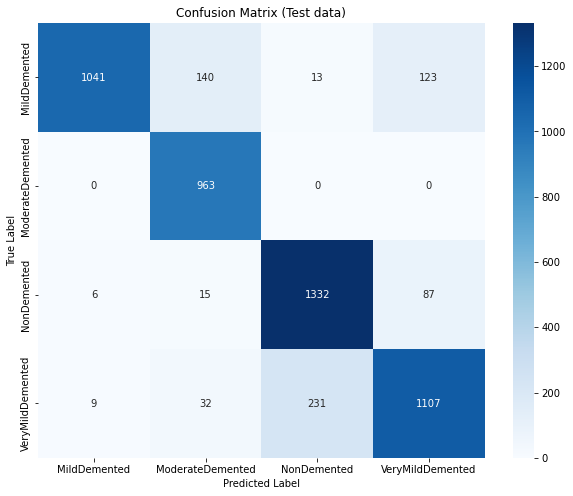

In [14]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(initial_ensemble, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Ensemble formation 1 : Model1_Test2 + Model_2_Test1

In [15]:
model1_test2 = CNN1(num_classes=4)
model1_test2.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test2.pth"))

model2_test1 = CNN2(num_classes=4)
model2_test1.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test1.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
model1_test2.eval()
model2_test1.eval()

ensemble_model1 = VotingEnsemble(model1_test2, model2_test1).to(device)

In [17]:
def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

In [84]:
true_labels1, predictions1 = evaluate_model(model1_test2, val_loader)
print('Model1_Test2 - Val set | VSCA')
print(classification_report(true_labels1, predictions1, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels1, predictions1 = evaluate_model(model1_test2, test_loader)
print('Model1_Test2 - Test set | Test accuracy')
print(classification_report(true_labels1, predictions1, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Model1_Test2 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.99      0.99      0.99      1439
VeryMildDemented       0.98      0.99      0.98      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097

Model1_Test2 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.98      0.99      0.99      1428
VeryMildDemented       0.99      0.98      0.98      1381

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      50

In [85]:
true_labels1, predictions1 = evaluate_model(model2_test1, val_loader)
print('model2_test1 - Val set | VSCA')
print(classification_report(true_labels1, predictions1, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels1, predictions1 = evaluate_model(model2_test1, test_loader)
print('model2_test1 - Test set | Test accuracy')
print(classification_report(true_labels1, predictions1, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_test1 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.85      0.90      0.87      1356
ModerateDemented       0.97      0.98      0.98       961
     NonDemented       0.85      0.86      0.86      1439
VeryMildDemented       0.84      0.77      0.80      1341

        accuracy                           0.87      5097
       macro avg       0.88      0.88      0.88      5097
    weighted avg       0.87      0.87      0.87      5097

model2_test1 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.85      0.90      0.87      1361
ModerateDemented       0.97      0.98      0.98       929
     NonDemented       0.86      0.86      0.86      1428
VeryMildDemented       0.83      0.78      0.80      1381

        accuracy                           0.87      5099
       macro avg       0.88      0.88      0.88      5099
    weighted avg       0.87      0.87      0.87      50

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.99      0.99      0.99      1439
VeryMildDemented       0.99      0.99      0.99      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097



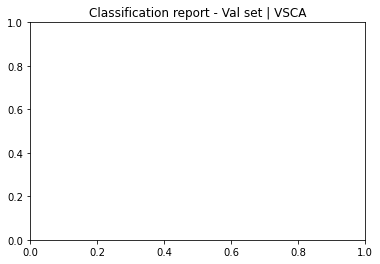

In [57]:
# Evaluate the model
true_labels, predictions = evaluate_model(ensemble_model1, val_loader)

# Print classification report
plt.title('Classification report - Val set | VSCA')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.98      0.99      0.99      1428
VeryMildDemented       0.99      0.99      0.99      1381

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      5099



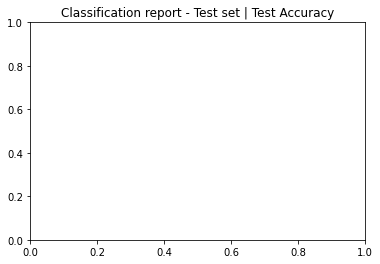

In [58]:
true_labels, predictions = evaluate_model(ensemble_model1, test_loader)

# Print classification report
plt.title('Classification report - Test set | Test Accuracy')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

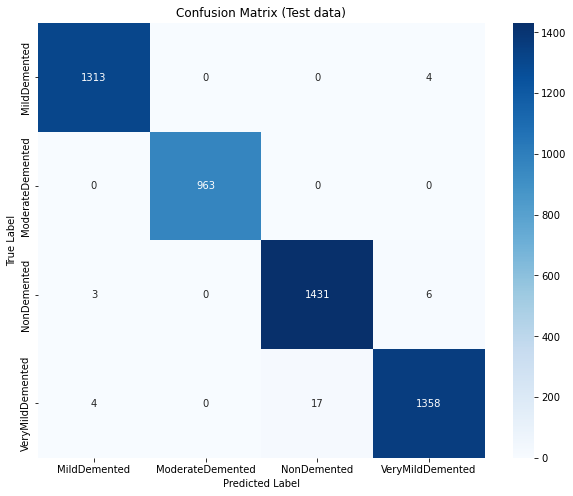

In [57]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels1, predictions1 = get_predictions(ensemble_model1, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels1, predictions1)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [58]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels1, predictions1)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels1, predictions1)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9910512196857119
Cohen's Kappa Coefficient: 0.9910462545965376


## 5-Fold Cross Validation for The Ensemble Model1 

Fold 1/5


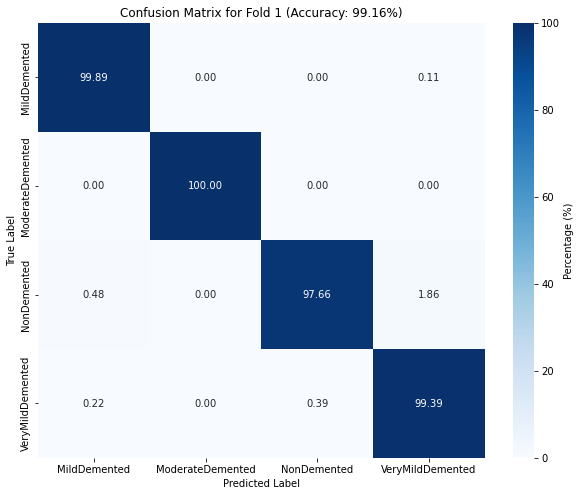

Fold 2/5


/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


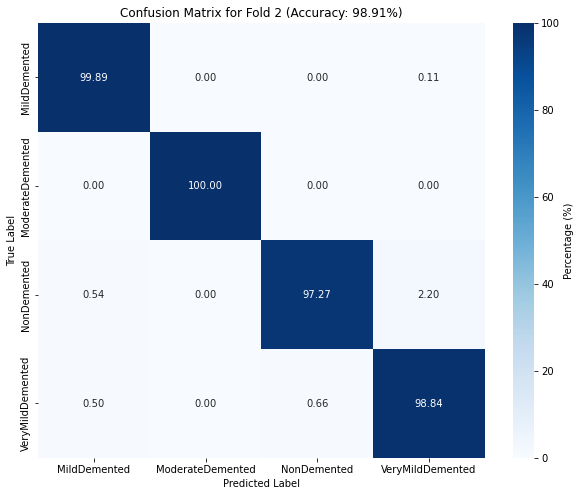

Fold 3/5


/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


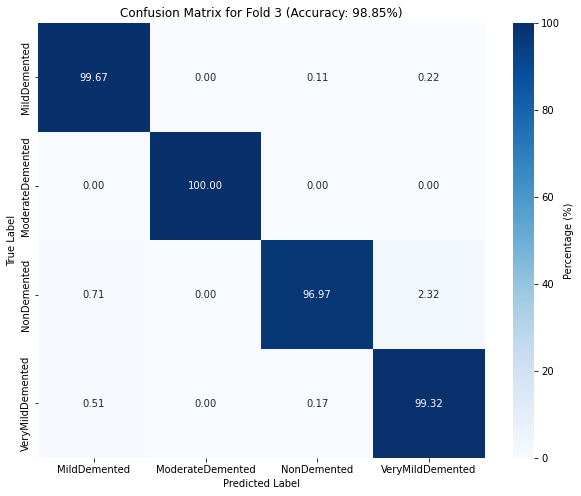

Fold 4/5


/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


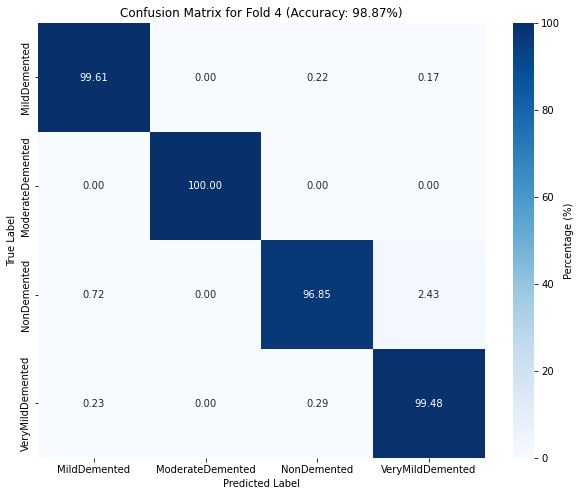

Fold 5/5


/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


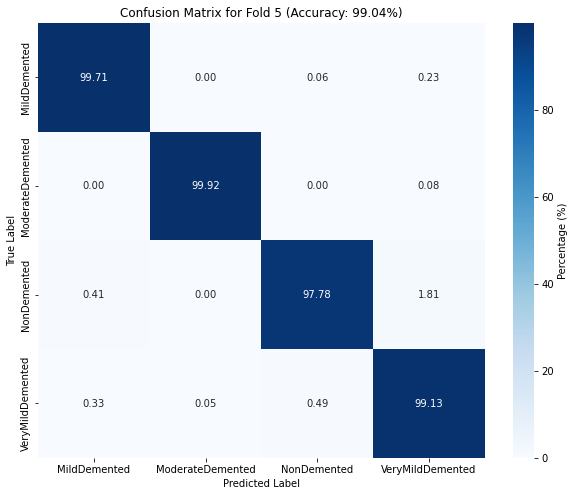

In [135]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

for fold, (train_idx, val_idx) in enumerate(kf.split(preprocessed_dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    val_subset = Subset(preprocessed_dataset, val_idx)
    
    model1_test2 = CNN1(num_classes=4)
    model1_test2.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test2.pth"))

    model2_test1 = CNN2(num_classes=4)
    model2_test1.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test1.pth"))
    
    ensemble_model1 = VotingEnsemble(model2_test1, model2_test1)
    ensemble_model1.eval()  # Set the model to evaluation mode
    
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    true_labels, predictions = get_predictions(ensemble_model, val_loader)
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    acc = accuracy_score(true_labels, predictions) * 100  # Calculate accuracy in percentage
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Percentage (%)'})
    plt.title(f'Confusion Matrix for Fold {fold+1} (Accuracy: {acc:.2f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


### Ensemble formation 2 : Model1_Test1 + Model_2_Test2

In [23]:
model1_test1 = CNN1(num_classes=4)
model1_test1.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test1.pth"))

model2_test2 = CNN2(num_classes=4)
model2_test2.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test2.pth"))

<All keys matched successfully>

In [24]:
model1_test1.eval()
model2_test2.eval()

ensemble_model2 = VotingEnsemble(model1_test1, model2_test2).to(device)

In [88]:
true_labels2, predictions2 = evaluate_model(model1_test1, val_loader)
print('model1_test1 - Val set | VSCA')
print(classification_report(true_labels2, predictions2, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels2, predictions2 = evaluate_model(model1_test1, test_loader)
print('model1_test1 - Test set | Test accuracy')
print(classification_report(true_labels2, predictions2, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model1_test1 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.90      1.00      0.94      1439
VeryMildDemented       0.99      0.90      0.94      1341

        accuracy                           0.96      5097
       macro avg       0.97      0.97      0.97      5097
    weighted avg       0.97      0.96      0.96      5097

model1_test1 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.89      0.99      0.94      1428
VeryMildDemented       0.99      0.89      0.94      1381

        accuracy                           0.96      5099
       macro avg       0.97      0.96      0.96      5099
    weighted avg       0.96      0.96      0.96      50

In [89]:
true_labels2, predictions2 = evaluate_model(model2_test2, val_loader)
print('model2_test2 - Val set | VSCA')
print(classification_report(true_labels2, predictions2, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels2, predictions2 = evaluate_model(model2_test2, test_loader)
print('model2_test2 - Test set | Test accuracy')
print(classification_report(true_labels2, predictions2, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_test2 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.78      0.83      0.81      1356
ModerateDemented       0.93      0.96      0.95       961
     NonDemented       0.83      0.65      0.73      1439
VeryMildDemented       0.66      0.76      0.71      1341

        accuracy                           0.79      5097
       macro avg       0.80      0.80      0.80      5097
    weighted avg       0.79      0.79      0.79      5097

model2_test2 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.80      0.81      0.80      1361
ModerateDemented       0.93      0.97      0.95       929
     NonDemented       0.85      0.64      0.73      1428
VeryMildDemented       0.63      0.76      0.69      1381

        accuracy                           0.78      5099
       macro avg       0.80      0.80      0.79      5099
    weighted avg       0.79      0.78      0.78      50

                  precision    recall  f1-score   support

    MildDemented       0.99      0.98      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.93      1.00      0.96      1439
VeryMildDemented       0.99      0.92      0.96      1341

        accuracy                           0.97      5097
       macro avg       0.98      0.98      0.98      5097
    weighted avg       0.98      0.97      0.97      5097



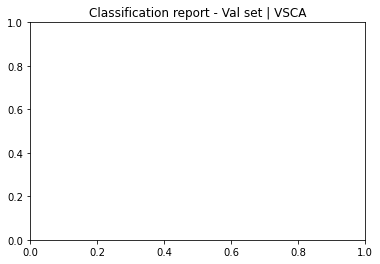

In [61]:
true_labels, predictions = evaluate_model(ensemble_model2, val_loader)

# Print classification report
plt.title('Classification report - Val set | VSCA')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.98      0.99      1361
ModerateDemented       0.99      1.00      1.00       929
     NonDemented       0.92      1.00      0.95      1428
VeryMildDemented       0.99      0.91      0.95      1381

        accuracy                           0.97      5099
       macro avg       0.97      0.97      0.97      5099
    weighted avg       0.97      0.97      0.97      5099



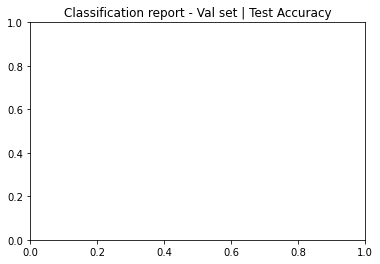

In [62]:
true_labels, predictions = evaluate_model(ensemble_model2, test_loader)

# Print classification report
plt.title('Classification report - Val set | Test Accuracy')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

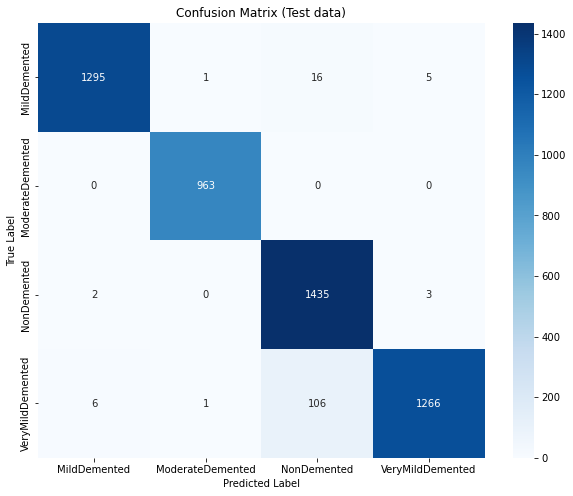

In [45]:
true_labels2, predictions2 = get_predictions(ensemble_model2, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels2, predictions2)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [46]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels2, predictions2)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels2, predictions2)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9637392963959648
Cohen's Kappa Coefficient: 0.9631185487102936


### Ensemble formation 3 : Model1_Test3 + Model_2_Test3

In [26]:
model1_test3 = CNN1(num_classes=4)
model1_test3.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test3.pth"))

model2_test3 = CNN2(num_classes=4)
model2_test3.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test3.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [27]:
model1_test3.eval()
model2_test3.eval()

ensemble_model3 = VotingEnsemble(model1_test3, model2_test3).to(device)

In [92]:
true_labels3, predictions3 = evaluate_model(model1_test3, val_loader)
print('model1_test3 - Val set | VSCA')
print(classification_report(true_labels3, predictions3, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels3, predictions3 = evaluate_model(model1_test3, test_loader)
print('model1_test3 - Test set | Test accuracy')
print(classification_report(true_labels3, predictions3, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model1_test3 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.97      0.99      0.98      1439
VeryMildDemented       0.99      0.96      0.97      1341

        accuracy                           0.98      5097
       macro avg       0.99      0.98      0.99      5097
    weighted avg       0.98      0.98      0.98      5097

model1_test3 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.96      0.99      0.98      1428
VeryMildDemented       0.99      0.96      0.97      1381

        accuracy                           0.98      5099
       macro avg       0.98      0.98      0.98      5099
    weighted avg       0.98      0.98      0.98      50

In [93]:
true_labels3, predictions3 = evaluate_model(model2_test3, val_loader)
print('model2_test3 - Val set | VSCA')
print(classification_report(true_labels3, predictions3, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels3, predictions3 = evaluate_model(model2_test3, test_loader)
print('model2_test3 - Test set | Test accuracy')
print(classification_report(true_labels3, predictions3, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_test3 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.82      0.88      0.85      1356
ModerateDemented       0.95      0.97      0.96       961
     NonDemented       0.82      0.83      0.82      1439
VeryMildDemented       0.81      0.71      0.76      1341

        accuracy                           0.84      5097
       macro avg       0.85      0.85      0.85      5097
    weighted avg       0.84      0.84      0.84      5097

model2_test3 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.81      0.86      0.83      1361
ModerateDemented       0.95      0.96      0.96       929
     NonDemented       0.79      0.83      0.81      1428
VeryMildDemented       0.80      0.70      0.74      1381

        accuracy                           0.83      5099
       macro avg       0.84      0.84      0.84      5099
    weighted avg       0.83      0.83      0.82      50

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.97      0.99      0.98      1439
VeryMildDemented       0.99      0.96      0.98      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097



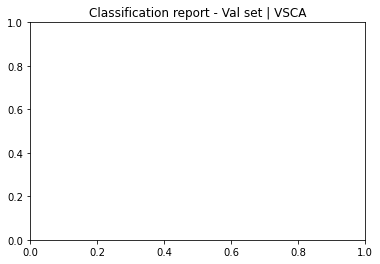

In [65]:
true_labels, predictions = evaluate_model(ensemble_model3, val_loader)

# Print classification report
plt.title('Classification report - Val set | VSCA')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.96      0.99      0.98      1428
VeryMildDemented       0.99      0.96      0.97      1381

        accuracy                           0.98      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.98      0.98      0.98      5099



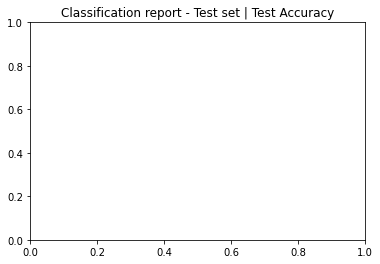

In [66]:
true_labels, predictions = evaluate_model(ensemble_model3, test_loader)

# Print classification report
plt.title('Classification report - Test set | Test Accuracy')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

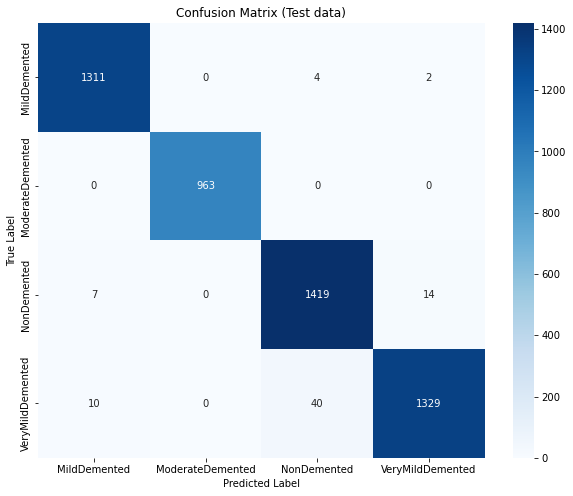

In [47]:
true_labels3, predictions3 = get_predictions(ensemble_model3, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels3, predictions3)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [48]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels3, predictions3)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels3, predictions3)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9797676589460683
Cohen's Kappa Coefficient: 0.9797219613013771


### Ensemble formation 4 : Model1_Test4 + Model_2_Test4

In [29]:
model1_test4 = CNN1(num_classes=4)
model1_test4.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test4.pth"))

model2_test4 = CNN2(num_classes=4)
model2_test4.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test4.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [30]:
model1_test4.eval()
model2_test4.eval()

ensemble_model4 = VotingEnsemble(model1_test4, model2_test4).to(device)

In [96]:
true_labels4, predictions4 = evaluate_model(model1_test4, val_loader)
print('model1_test4 - Val set | VSCA')
print(classification_report(true_labels4, predictions4, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels4, predictions4 = evaluate_model(model1_test4, test_loader)
print('model1_test4 - Test set | Test accuracy')
print(classification_report(true_labels4, predictions4, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model1_test4 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.99      0.97      0.98      1439
VeryMildDemented       0.97      0.99      0.98      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097

model1_test4 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.99      0.97      0.98      1428
VeryMildDemented       0.97      0.99      0.98      1381

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      50

In [97]:
true_labels4, predictions4 = evaluate_model(model2_test4, val_loader)
print('model2_test4 - Val set | VSCA')
print(classification_report(true_labels4, predictions4, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels4, predictions4 = evaluate_model(model2_test4, test_loader)
print('model2_test4 - Test set | Test accuracy')
print(classification_report(true_labels4, predictions4, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_test4 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.80      0.89      0.84      1356
ModerateDemented       0.94      0.98      0.96       961
     NonDemented       0.85      0.81      0.83      1439
VeryMildDemented       0.80      0.73      0.76      1341

        accuracy                           0.84      5097
       macro avg       0.85      0.85      0.85      5097
    weighted avg       0.84      0.84      0.84      5097

model2_test4 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.80      0.88      0.84      1361
ModerateDemented       0.92      0.98      0.95       929
     NonDemented       0.85      0.81      0.83      1428
VeryMildDemented       0.82      0.73      0.77      1381

        accuracy                           0.84      5099
       macro avg       0.85      0.85      0.85      5099
    weighted avg       0.84      0.84      0.84      50

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       1.00      0.98      0.99      1439
VeryMildDemented       0.98      0.99      0.99      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097



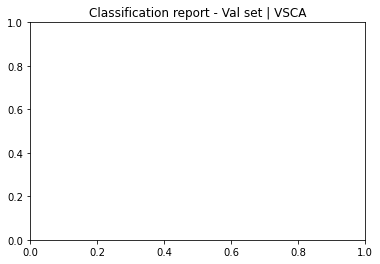

In [69]:
true_labels, predictions = evaluate_model(ensemble_model4, val_loader)

# Print classification report
plt.title('Classification report - Val set | VSCA')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       1.00      0.97      0.98      1428
VeryMildDemented       0.98      0.99      0.98      1381

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      5099



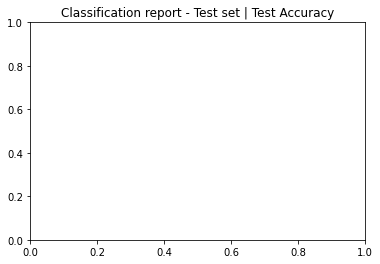

In [70]:
true_labels, predictions = evaluate_model(ensemble_model4, test_loader)

# Print classification report
plt.title('Classification report - Test set | Test Accuracy')
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

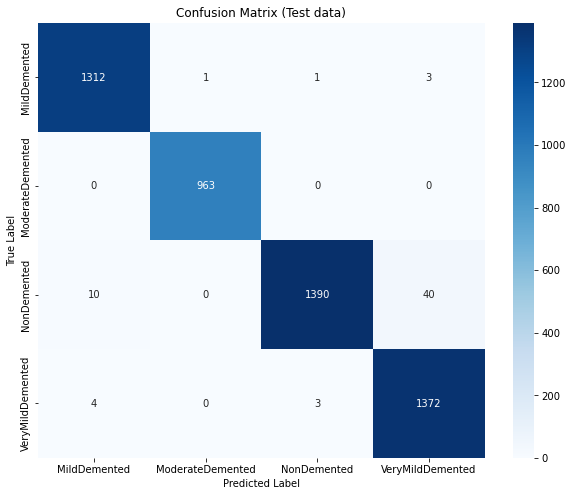

In [49]:
true_labels4, predictions4 = get_predictions(ensemble_model4, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels4, predictions4)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [50]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels4, predictions4)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels4, predictions4)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9837647716317486
Cohen's Kappa Coefficient: 0.9836760233479679


### Ensemble formation 5 : Model1_Test5 + Model_2_Test5

In [32]:
model1_test5 = CNN1(num_classes=4)
model1_test5.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test5.pth"))

model2_test5 = CNN2(num_classes=4)
model2_test5.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test5.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [33]:
model1_test5.eval()
model2_test5.eval()

ensemble_model5 = VotingEnsemble(model1_test5, model2_test5).to(device)

In [100]:
true_labels5, predictions5 = evaluate_model(model1_test5, val_loader)
print('model1_test5 - Val set | VSCA')
print(classification_report(true_labels5, predictions5, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels5, predictions5 = evaluate_model(model1_test5, test_loader)
print('model1_test5 - Test set | Test accuracy')
print(classification_report(true_labels5, predictions5, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model1_test5 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.88      1.00      0.93      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       1.00      0.70      0.83      1439
VeryMildDemented       0.81      0.95      0.87      1341

        accuracy                           0.90      5097
       macro avg       0.92      0.91      0.91      5097
    weighted avg       0.92      0.90      0.90      5097

model1_test5 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.89      1.00      0.94      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       1.00      0.69      0.81      1428
VeryMildDemented       0.80      0.97      0.87      1381

        accuracy                           0.90      5099
       macro avg       0.92      0.91      0.91      5099
    weighted avg       0.92      0.90      0.90      50

In [101]:
true_labels5, predictions5 = evaluate_model(model2_test5, val_loader)
print('model2_test5 - Val set | VSCA')
print(classification_report(true_labels5, predictions5, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels5, predictions5 = evaluate_model(model2_test5, test_loader)
print('model2_test5 - Test set | Test accuracy')
print(classification_report(true_labels5, predictions5, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_test5 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.85      0.89      0.87      1356
ModerateDemented       0.96      0.97      0.97       961
     NonDemented       0.88      0.84      0.86      1439
VeryMildDemented       0.81      0.80      0.80      1341

        accuracy                           0.87      5097
       macro avg       0.87      0.88      0.87      5097
    weighted avg       0.87      0.87      0.87      5097

model2_test5 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.84      0.89      0.87      1361
ModerateDemented       0.95      0.98      0.96       929
     NonDemented       0.89      0.84      0.86      1428
VeryMildDemented       0.83      0.82      0.82      1381

        accuracy                           0.87      5099
       macro avg       0.88      0.88      0.88      5099
    weighted avg       0.87      0.87      0.87      50

In [76]:
true_labels, predictions = evaluate_model(ensemble_model5, val_loader)

# Print classification report | VSCA
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.90      1.00      0.94      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       1.00      0.76      0.86      1439
VeryMildDemented       0.84      0.96      0.90      1341

        accuracy                           0.92      5097
       macro avg       0.93      0.93      0.93      5097
    weighted avg       0.93      0.92      0.92      5097



In [77]:
true_labels, predictions = evaluate_model(ensemble_model5, test_loader)

# Print classification report | Test Accuracy
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.92      1.00      0.96      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       1.00      0.76      0.86      1428
VeryMildDemented       0.84      0.97      0.90      1381

        accuracy                           0.92      5099
       macro avg       0.94      0.93      0.93      5099
    weighted avg       0.93      0.92      0.92      5099



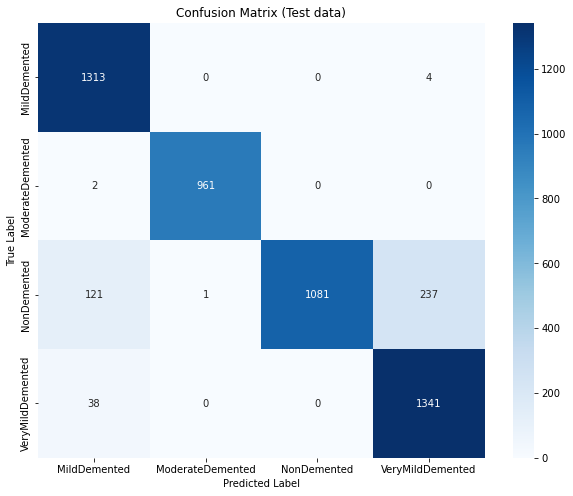

In [51]:
true_labels5, predictions5 = get_predictions(ensemble_model5, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels5, predictions5)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [52]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels5, predictions5)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels5, predictions5)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.8985608717684765
Cohen's Kappa Coefficient: 0.8940442620184192


### Ensemble formation 6 : Model1_Test7 + Model_2_Test5

In [35]:
model1_test7 = CNN1(num_classes=4)
model1_test7.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test7.pth"))

model2_test5 = CNN2(num_classes=4)
model2_test5.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test5.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [36]:
model1_test7.eval()
model2_test5.eval()

ensemble_model6 = VotingEnsemble(model1_test7, model2_test5).to(device)

In [105]:
true_labels6, predictions6 = evaluate_model(model1_test7, val_loader)
print('model1_test7 - Val set | VSCA')
print(classification_report(true_labels6, predictions6, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels6, predictions6 = evaluate_model(model1_test7, test_loader)
print('model1_test7 - Test set | Test accuracy')
print(classification_report(true_labels6, predictions6, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

# classification reports for model2_test5 is done above

model1_test7 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.98      0.99      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.98      0.94      0.96      1439
VeryMildDemented       0.94      0.97      0.95      1341

        accuracy                           0.97      5097
       macro avg       0.98      0.98      0.98      5097
    weighted avg       0.97      0.97      0.97      5097

model1_test7 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.98      0.99      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.98      0.94      0.96      1428
VeryMildDemented       0.94      0.97      0.95      1381

        accuracy                           0.97      5099
       macro avg       0.98      0.98      0.97      5099
    weighted avg       0.97      0.97      0.97      50

In [108]:
true_labels, predictions = evaluate_model(ensemble_model6, val_loader)

# Print classification report | VSCA
print("Ensemble formation 6 - VSCA")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation 6 - VSCA
                  precision    recall  f1-score   support

    MildDemented       0.98      1.00      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.99      0.96      0.97      1439
VeryMildDemented       0.96      0.98      0.97      1341

        accuracy                           0.98      5097
       macro avg       0.98      0.98      0.98      5097
    weighted avg       0.98      0.98      0.98      5097



In [109]:
true_labels, predictions = evaluate_model(ensemble_model6, test_loader)

# Print classification report | VSCA
print("Ensemble formation 6 - Test Accuracy")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation 6 - Test Accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.98      0.95      0.97      1428
VeryMildDemented       0.96      0.97      0.96      1381

        accuracy                           0.98      5099
       macro avg       0.98      0.98      0.98      5099
    weighted avg       0.98      0.98      0.98      5099



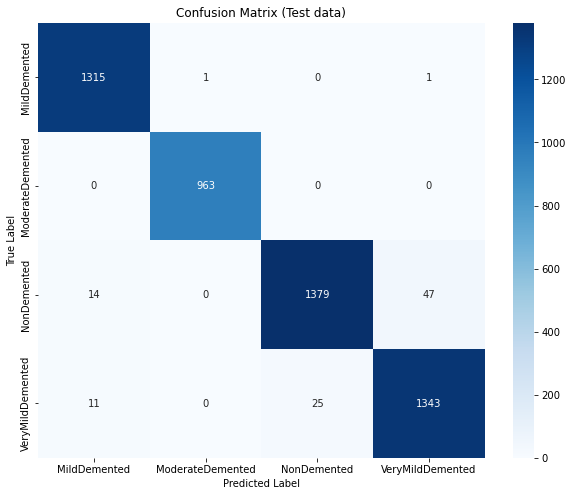

In [53]:
true_labels6, predictions6 = get_predictions(ensemble_model6, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels6, predictions6)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [54]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels6, predictions6)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels6, predictions6)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9739841919094343
Cohen's Kappa Coefficient: 0.9739346425882724


### Ensemble formation 7 : Model1_Test6 + Model_2_Test5

In [38]:
model1_test6 = CNN1(num_classes=4)
model1_test6.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_test6.pth"))

model2_test2 = CNN2(num_classes=4)
model2_test2.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_test2.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [39]:
model1_test6.eval()
model2_test2.eval()

ensemble_model7 = VotingEnsemble(model1_test6, model2_test2).to(device)

In [115]:
true_labels7, predictions7 = evaluate_model(model1_test6, val_loader)
print('model1_test6 - Val set | VSCA')
print(classification_report(true_labels7, predictions7, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labels7, predictions7 = evaluate_model(model1_test6, test_loader)
print('model1_test6 - Test set | Test accuracy')
print(classification_report(true_labels7, predictions7, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

# classification reports for model2_test2 is done above

model1_test6 - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.98      0.99      0.98      1439
VeryMildDemented       0.99      0.97      0.98      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097

model1_test6 - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.96      0.99      0.97      1428
VeryMildDemented       1.00      0.95      0.97      1381

        accuracy                           0.98      5099
       macro avg       0.99      0.98      0.98      5099
    weighted avg       0.98      0.98      0.98      50

In [116]:
true_labels, predictions = evaluate_model(ensemble_model7, val_loader)

# Print classification report | VSCA
print("Ensemble formation 7 - VSCA")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation 7 - VSCA
                  precision    recall  f1-score   support

    MildDemented       0.98      1.00      0.99      1356
ModerateDemented       1.00      1.00      1.00       961
     NonDemented       0.98      0.99      0.99      1439
VeryMildDemented       0.99      0.97      0.98      1341

        accuracy                           0.99      5097
       macro avg       0.99      0.99      0.99      5097
    weighted avg       0.99      0.99      0.99      5097



In [117]:
true_labels, predictions = evaluate_model(ensemble_model7, test_loader)

# Print classification report | VSCA
print("Ensemble formation 7 - VSCA")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation 7 - VSCA
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99      1361
ModerateDemented       1.00      1.00      1.00       929
     NonDemented       0.97      0.99      0.98      1428
VeryMildDemented       1.00      0.96      0.98      1381

        accuracy                           0.99      5099
       macro avg       0.99      0.99      0.99      5099
    weighted avg       0.99      0.99      0.99      5099



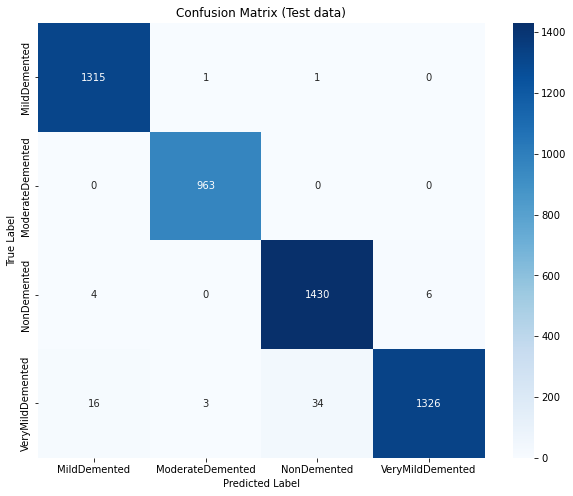

In [55]:
true_labels7, predictions7 = get_predictions(ensemble_model7, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels7, predictions7)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [56]:
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels7, predictions7)

print("Matthews Correlation Coefficient (MCC):", mcc)

# Calculate Cohen's Kappa Coefficient
kappa = cohen_kappa_score(true_labels7, predictions7)

print("Cohen's Kappa Coefficient:", kappa)

Matthews Correlation Coefficient (MCC): 0.9829644822817587
Cohen's Kappa Coefficient: 0.9828839219174056


### Generalisability Testing of the Ensemble Model 

In [41]:
model1_generalization_test = CNN1(num_classes=4)
model1_generalization_test.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model1_generalization_test.pth"))

model2_generalization_test = CNN2(num_classes=4)
model2_generalization_test.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_generalization_test.pth"))

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/savin/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [13]:
model1_generalization_test.eval()
model2_generalization_test.eval()

ensemble_model_G = VotingEnsemble(model1_generalization_test, model2_generalization_test).to(device)

In [14]:
true_labelsG, predictionsG = evaluate_model(model1_generalization_test, val_loader)
print('model1_generalization_test - Val set | VSCA')
print(classification_report(true_labelsG, predictionsG, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labelsG, predictionsG = evaluate_model(model1_generalization_test, test_loader)
print('model1_generalization_test - Test set | Test accuracy')
print(classification_report(true_labelsG, predictionsG, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model1_generalization_test - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       745
ModerateDemented       0.00      0.00      0.00        88
     NonDemented       0.61      0.28      0.39       758
VeryMildDemented       0.34      0.90      0.49       734

        accuracy                           0.38      2325
       macro avg       0.24      0.30      0.22      2325
    weighted avg       0.31      0.38      0.28      2325

model1_generalization_test - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       1.00      0.00      0.00       704
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.59      0.30      0.40       746
VeryMildDemented       0.37      0.90      0.53       811

        accuracy                           0.41      2325
       macro avg       0.49      0.30      0.23      2325
    weighted avg       0.62

In [15]:
true_labelsG, predictionsG = evaluate_model(model2_generalization_test, val_loader)
print('model2_generalization_test - Val set | VSCA')
print(classification_report(true_labelsG, predictionsG, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

true_labelsG, predictionsG = evaluate_model(model2_generalization_test, test_loader)
print('model2_generalization_test - Test set | Test accuracy')
print(classification_report(true_labelsG, predictionsG, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

model2_generalization_test - Val set | VSCA
                  precision    recall  f1-score   support

    MildDemented       0.66      0.19      0.30       745
ModerateDemented       0.05      0.03      0.04        88
     NonDemented       0.51      0.62      0.56       758
VeryMildDemented       0.38      0.58      0.46       734

        accuracy                           0.45      2325
       macro avg       0.40      0.36      0.34      2325
    weighted avg       0.50      0.45      0.42      2325

model2_generalization_test - Test set | Test accuracy
                  precision    recall  f1-score   support

    MildDemented       0.68      0.20      0.31       704
ModerateDemented       0.10      0.09      0.10        64
     NonDemented       0.50      0.59      0.54       746
VeryMildDemented       0.43      0.63      0.51       811

        accuracy                           0.47      2325
       macro avg       0.43      0.38      0.36      2325
    weighted avg       0.52

In [16]:
true_labels, predictions = evaluate_model(ensemble_model_G, val_loader)

# Print classification report | VSCA
print("Ensemble formation G - VSCA")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation G - VSCA
                  precision    recall  f1-score   support

    MildDemented       1.00      0.00      0.01       745
ModerateDemented       0.00      0.00      0.00        88
     NonDemented       0.69      0.33      0.44       758
VeryMildDemented       0.34      0.92      0.50       734

        accuracy                           0.40      2325
       macro avg       0.51      0.31      0.24      2325
    weighted avg       0.65      0.40      0.30      2325



In [17]:
true_labels, predictions = evaluate_model(ensemble_model_G, test_loader)

# Print classification report | VSCA
print("Ensemble formation G - Test")
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

Ensemble formation G - Test
                  precision    recall  f1-score   support

    MildDemented       1.00      0.01      0.01       704
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.67      0.34      0.45       746
VeryMildDemented       0.38      0.91      0.53       811

        accuracy                           0.43      2325
       macro avg       0.51      0.31      0.25      2325
    weighted avg       0.65      0.43      0.33      2325



In [18]:
true_labels, predictions = get_predictions(ensemble_model_G, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

NameError: name 'get_predictions' is not defined